In [14]:
import sqlite3
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import tree




In [15]:
connection = sqlite3.connect("myTable.db") 
crsr = connection.cursor()
sql_command = """SELECT * FROM musuem;"""
crsr.execute(sql_command)
myresult = crsr.fetchall()
x = []
y = []
for row in myresult:
    x.append(row[4])
    y.append(row[2])
x = np.asarray(x)
y = np.asarray(y)

Split the data into train, valid, test data

In [16]:
x = x/10000
y = y/10000
print(x.mean())
print(y.mean())
print(x.var())


1270.1781377049183
355.2321852459017
550455.3924586902


In [17]:

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

31920.93377714522


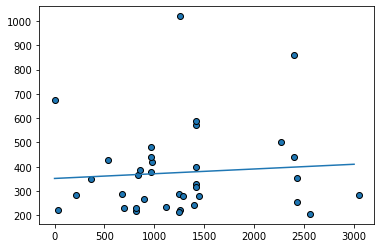

19559.942259028187
13563.26141714199


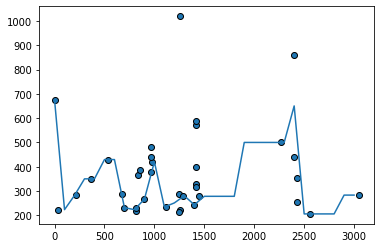

40990.2706012137


In [21]:
clf = LinearRegression()
#clf = MLPRegressor(random_state=0, activation='logistic', hidden_layer_sizes=16)
#clf = tree.DecisionTreeRegressor()
clf.fit(X_train.reshape(-1,1), y_train)
prediction = clf.predict(X_train.reshape(-1,1))
print(mean_squared_error(y_train, prediction))

fig, ax = plt.subplots()
ax.scatter(X_train, y_train, edgecolors=(0, 0, 0))

xmin = min(X_train)
xmax = max(X_train)
#print(X_train)

xx = np.arange(xmin,xmax, 100)
yy = clf.predict(xx.reshape(-1,1))
ax.plot(xx,yy)
plt.show()

prediction = clf.predict(X_val.reshape(-1,1))
print(mean_squared_error(y_val, prediction))


#clf = LinearRegression()
#clf = MLPRegressor(random_state=0, activation='logistic', hidden_layer_sizes=16)
clf = tree.DecisionTreeRegressor()
clf.fit(X_train.reshape(-1,1), y_train)
prediction = clf.predict(X_train.reshape(-1,1))
print(mean_squared_error(y_train, prediction))

fig, ax = plt.subplots()
ax.scatter(X_train, y_train, edgecolors=(0, 0, 0))

xmin = min(X_train)
xmax = max(X_train)
#print(X_train)

xx = np.arange(xmin,xmax, 100)
yy = clf.predict(xx.reshape(-1,1))
ax.plot(xx,yy)
plt.show()

prediction = clf.predict(X_val.reshape(-1,1))
print(mean_squared_error(y_val, prediction))
